In [1]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd



In [6]:
df = px.data.tips()
fig = go.Figure()
fig = px.scatter(df, x="total_bill", y="tip", color="sex", trendline="ols")
fig.show()

In [3]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [32]:
wd = "D:/Projects/Tools/crb_apexmf/crb_apexmf_git/resources/watershed/Upper Green (calibrated)"
start_date = "1/1/1995"
cal_start = "1/1/2000"
cal_end = "12/31/2012"
grid_ids = [4243, 4609, 5315, 6491, 12001, 16333, 17036, 17257]
obd_nams = [f'wt{i:05d}' for i in grid_id]


# def wt_df(wd, start_date, grid_id, obd_nam):
mf_obs = pd.read_csv(
                    os.path.join("./resources/watershed", wd, "modflow.obs"),
                    delim_whitespace=True,
                    skiprows = 2,
                    usecols = [3, 4],
                    index_col = 0,
                    names = ["grid_id", "mf_elev"],)


def tot_wt(start_date, cal_start, cal_end, grid_ids, obd_nams, time_step=None):
    """combine all groundwater outputs to provide a dataframe for 1 to 1 plot

    Args:
        start_date (str): simulation start date 
        grid_ids (list): list of grid ids used for plot
        obd_nams (list): list of column names in observed data and in accordance with grid ids
        time_step (str, optional): simulation time step (day, month, annual). Defaults to None.

    Returns:
        dataframe: dataframe for all simulated groundwater levels and observed data
    """
    if time_step is None:
        time_step = "D"
        mfobd_file = "dtw_day.obd"
    else:
        time_step = "M"
        mfobd_file = "modflow_month.obd."
    # read obs and obd files to get grid ids, elev, and observed values
    mf_obs = pd.read_csv(
                        os.path.join("./resources/watershed", wd, "modflow.obs"),
                        delim_whitespace=True,
                        skiprows = 2,
                        usecols = [3, 4],
                        index_col = 0,
                        names = ["grid_id", "mf_elev"],)
    mfobd_df = pd.read_csv(
                        os.path.join("./resources/watershed", wd, mfobd_file),
                        sep='\s+',
                        index_col=0,
                        header=0,
                        parse_dates=True,
                        na_values=[-999, ""],
                        delimiter="\t")
    grid_id_lst = mf_obs.index.astype(str).values.tolist()
    # read simulated water elevation
    output_wt = pd.read_csv(
                        os.path.join("./resources/watershed", wd, "apexmf_out_MF_obs"),
                        delim_whitespace=True,
                        skiprows = 1,
                        names = grid_id_lst,)
    # append data to big dataframe

    tot_df = pd.DataFrame()
    for grid_id, obd_nam in zip(grid_ids, obd_nams):
        # df = output_wt[str(grid_id)] - float(mf_obs.loc[int(grid_id)]) # calculate depth to water
        df = output_wt[str(grid_id)]
        df.index = pd.date_range(start_date, periods=len(df))
        df = df[cal_start:cal_end]
        if time_step == 'M':
            df = df.resample('M').mean()
        # mfobd_df = float(mf_obs.loc[int(grid_id)]) + mfobd_df[obd_nam]
        mfobd_dff = mfobd_df[obd_nam] + float(mf_obs.loc[int(grid_id)])
        df = pd.concat([df, mfobd_dff], axis=1) # concat sim with obd
        df = df.dropna() # drop nan
        new_cols ={x:y for x, y in zip(df.columns, ['sim', 'obd'])} #replace col nams with new nams
        df['grid_id'] = str(grid_id)
        tot_df = tot_df.append(df.rename(columns=new_cols))
    return tot_df

a = tot_wt(start_date, cal_start, cal_end, grid_ids, obd_nams, time_step=None)


,sim,obd,grid_id
2004-09-23,2271.05,2271.18,4243
2005-04-25,2271.41,2271.46,4243
2010-08-19,2277.11,2271.15,4243
2004-09-23,2222.41,2223.03,4609
2005-04-26,2222.61,2226.08,4609
...,...,...,...
2002-03-28,1914.40,1914.41,17036
2009-12-17,1914.42,1914.58,17036
2001-09-26,1879.04,1878.40,17257
2002-03-30,1879.03,1878.86,17257


<AxesSubplot:xlabel='sim', ylabel='obd'>

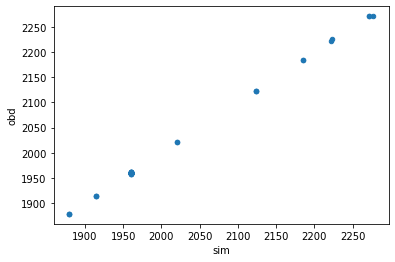

In [34]:
a.plot.scatter(x='sim', y='obd')

In [35]:
def get_val_info(wd):
    if os.path.isfile(os.path.join("./resources/watershed", wd, "interactive.dat")):
        with open(os.path.join("./resources/watershed", wd, 'interactive.dat'), "r") as f:
            data = [x.strip().split() for x in f if x.strip()]
        calstyr = int(data[0][0])
        caledyr = int(data[0][1])
        sims = [int(x) for x in data[1]]
        obds = [x for x in data[2]]
        gw_sims = [int(x) for x in data[3]]
        gw_obds = [x for x in data[4]]
        return calstyr, caledyr, sims, obds, gw_sims, gw_obds

In [36]:
b = get_val_info(wd)

ValueError: invalid literal for int() with base 10: 'wt04243'